In [123]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
def plot_corr_heatmap(data, figsize=(20, 20), cmap='coolwarm', center=0):
    corrmat = data.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corrmat, annot=True, cmap=cmap, center=center)
    plt.show()

In [124]:
!pip install yellowbrick



In [125]:
data = pd.read_csv("C:\\Users\\tanis\\Downloads\\customer\\marketing_campaign.csv", sep="\t")


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [127]:
data = data.dropna()


In [128]:
print(len(data))

2216


In [129]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = [i.date() for i in data["Dt_Customer"]]
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))


The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [130]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [131]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [132]:
# Feature Engineering

# Age of customer today 
data["Age"] = 2021 - data["Year_Birth"]

# Total spendings on various items
data["Spent"] = data.loc[:, "MntWines":"MntGoldProds"].sum(axis=1)

# Deriving living situation by marital status"Alone"
marital_status_map = {"Married":"Partner", "Together":"Partner", "Absurd":"Alone", 
                      "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"}
data["Living_With"] = data["Marital_Status"].map(marital_status_map)

# Feature indicating total children living in the household
data["Children"] = data[["Kidhome","Teenhome"]].sum(axis=1)

# Feature for total members in the household
living_with_map = {"Alone": 1, "Partner":2}
data["Family_Size"] = data["Living_With"].map(living_with_map) + data["Children"]

# Feature pertaining parenthood
data["Is_Parent"] = (data.Children > 0).astype(int)

# Segmenting education levels in three groups
education_map = {"Basic":"Undergraduate","2n Cycle":"Undergraduate", 
                 "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"}
data["Education"] = data["Education"].map(education_map)

# For clarity
rename_dict = {"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
               "MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"}
data.rename(columns=rename_dict, inplace=True)

# Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data.drop(to_drop, axis=1, inplace=True)


In [133]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2213.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592408,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.906165,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


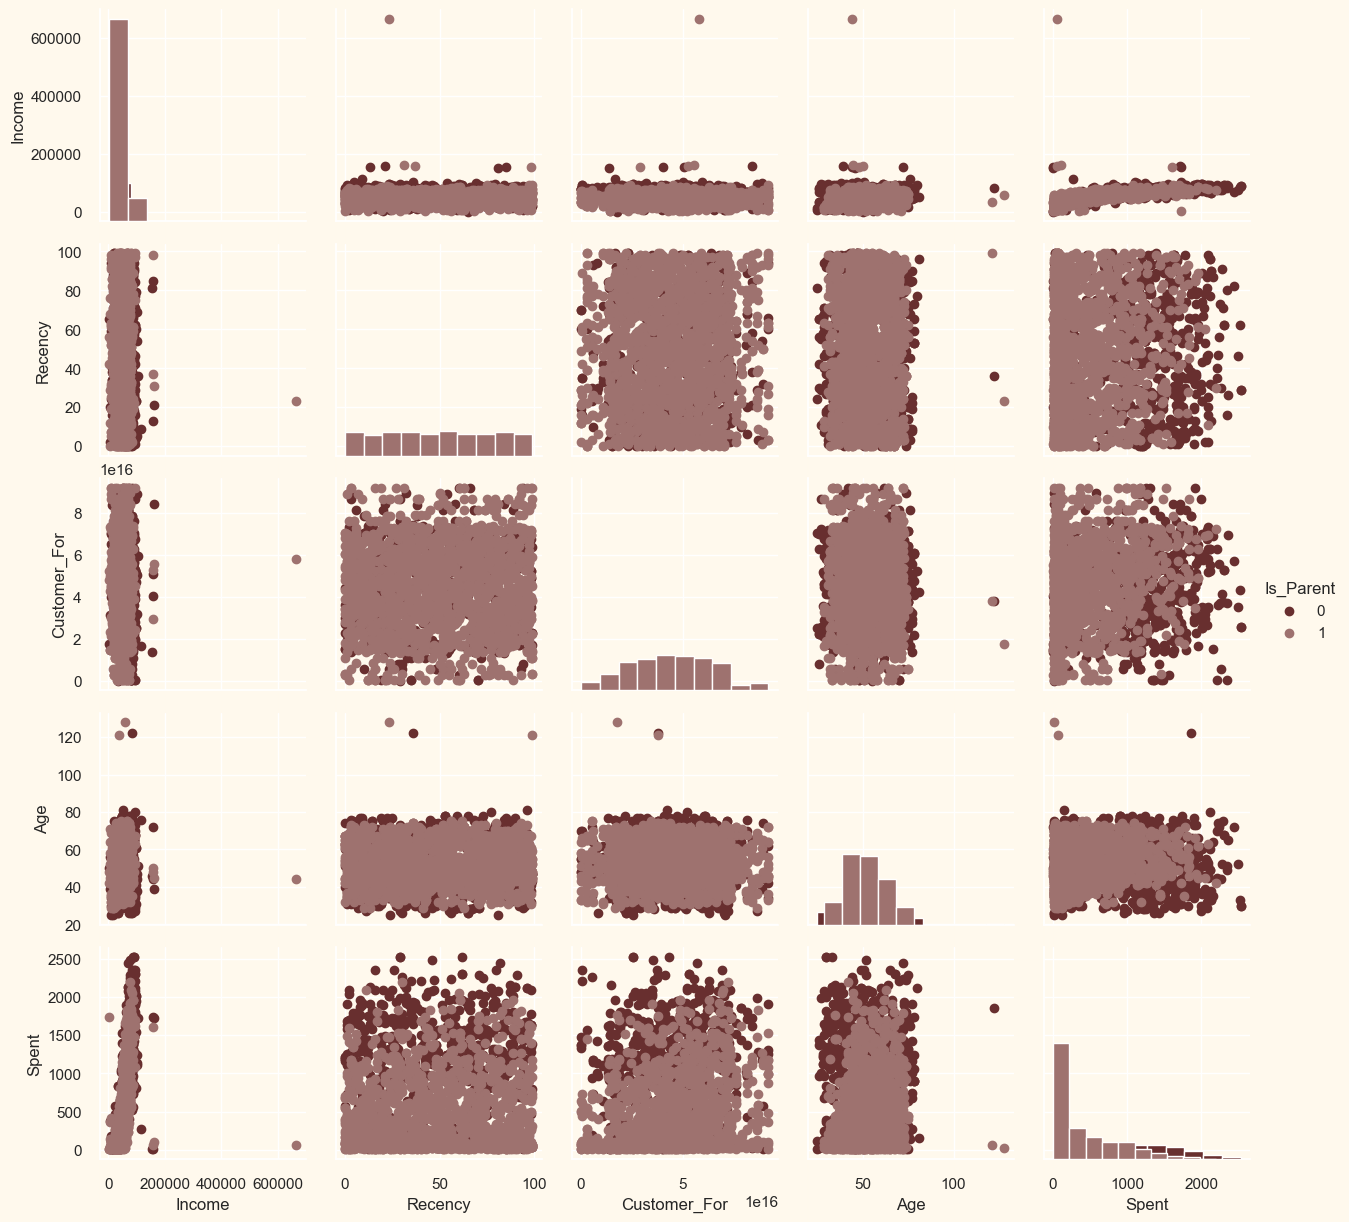

In [134]:
# Setting up colors preferences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]

# Plotting selected features
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")

# Using PairGrid for more control over the plot
grid = sns.PairGrid(data[to_plot], hue="Is_Parent", palette=palette)
grid = grid.map_diag(plt.hist)  # Diagonal - histogram
grid = grid.map_offdiag(plt.scatter)  # Non-diagonal - scatterplot
grid = grid.add_legend()  # Adding legend

plt.show()


In [135]:

data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2215


In [136]:
data = data[(data["Age"]<90)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


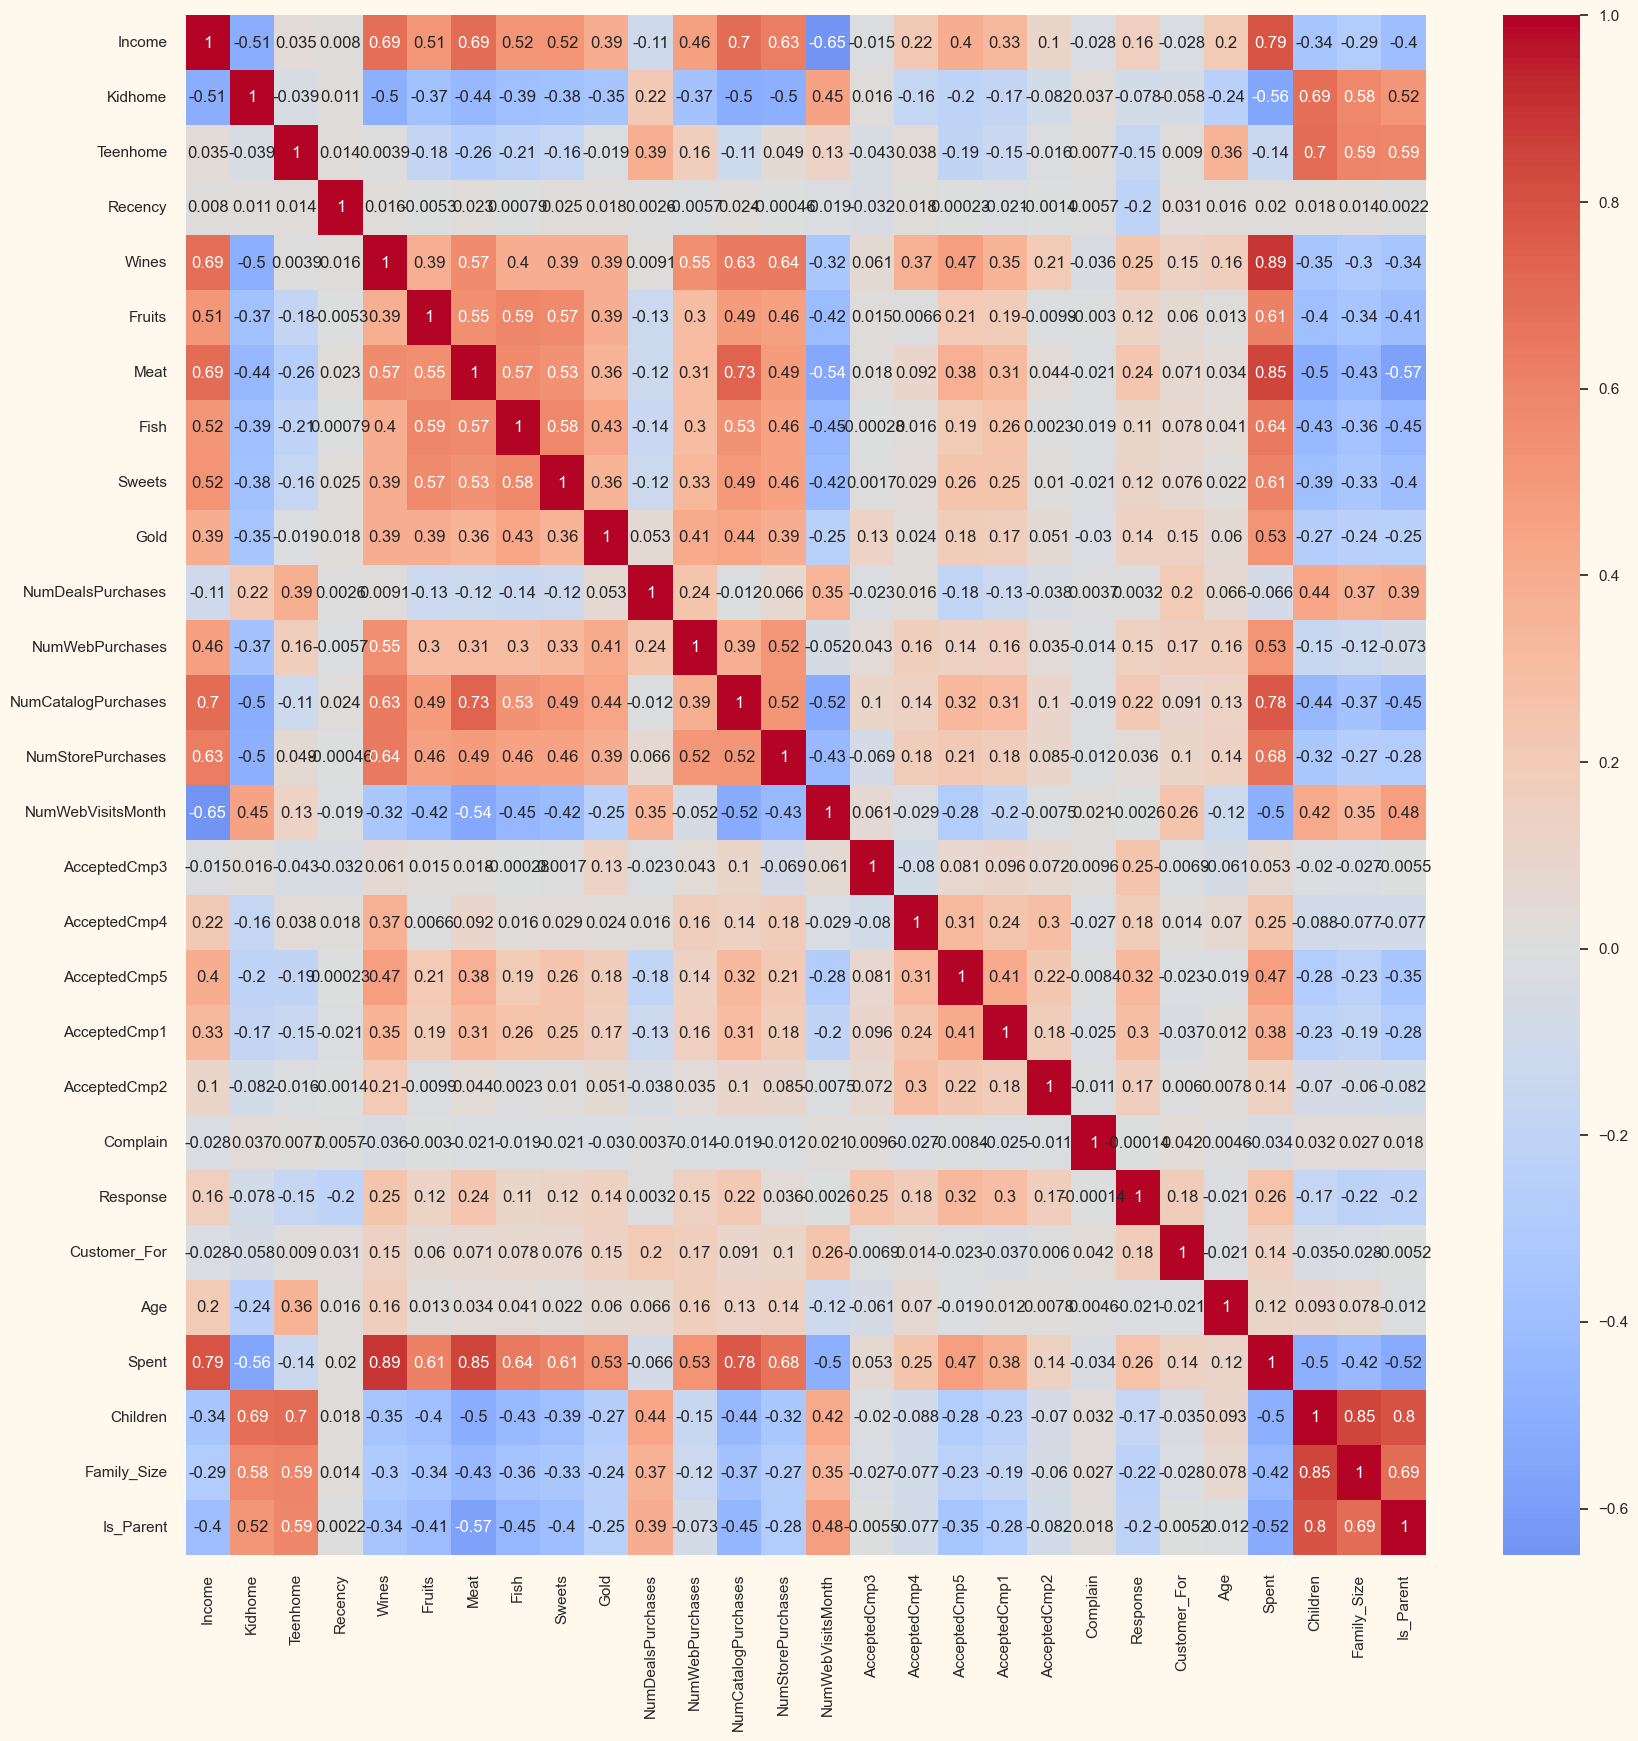

In [137]:
plot_corr_heatmap(data)

In [138]:
#Data Preprocessing

In [139]:
object_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Number of categorical variables in the dataset: ", len(object_cols))
print("Categorical variables in the dataset: ", object_cols)


Number of categorical variables in the dataset:  2
Categorical variables in the dataset:  ['Education', 'Living_With']


In [140]:
le = LabelEncoder()
for col in object_cols:
    data[col] = le.fit_transform(data[col])
print(data)

      Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
0             0  58138.0        0         0       58    635      88   546   
1             0  46344.0        1         1       38     11       1     6   
2             0  71613.0        0         0       26    426      49   127   
3             0  26646.0        1         0       26     11       4    20   
4             1  58293.0        1         0       94    173      43   118   
...         ...      ...      ...       ...      ...    ...     ...   ...   
2235          0  61223.0        0         1       46    709      43   182   
2236          1  64014.0        2         1       56    406       0    30   
2237          0  56981.0        0         0       91    908      48   217   
2238          1  69245.0        0         1        8    428      30   214   
2239          1  52869.0        1         1       40     84       3    61   

      Fish  Sweets  ...  AcceptedCmp2  Complain  Response       Customer_Fo

In [148]:
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
data_scaled  = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")
# Create a StandardScaler object
scaler = StandardScaler()
print(data_scaled)

All features are now scaled
      Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0     -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1     -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2     -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3     -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4      0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   
...         ...       ...       ...       ...       ...       ...       ...   
2207  -0.893586  0.430444 -0.822754  0.908097 -0.104347  1.197084  0.419540   
2208   0.571657  0.560123  2.902796  0.908097  0.241237  0.298631 -0.662628   
2209  -0.893586  0.233347 -0.822754 -0.929699  1.450778  1.787156  0.545373   
2210   0.571657  0.803172 -0.822754  0.908097 -1.417564  0.363866  0.092373   
2211   0.571657  0.042290  1.040021  0.908097 -0.311697 -0.656159 -0.587128   

          Meat      Fis

In [142]:
print("We will use these Dataframe for further modelling:")
data_scaled.head()

We will use these Dataframe for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349636,-1.264598,-1.757386,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349636,1.404572,0.448960,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.732230,-1.264598,-0.654213,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.732230,0.069987,0.448960,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.732230,0.069987,0.448960,0.632456


In [143]:
#Dimensional Reduction

In [151]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_scaled_imputed = imputer.fit_transform(data_scaled)
pca = PCA(n_components=3)
pca.fit(data_scaled_imputed)  # or pca.fit(data_scaled) if you used dropna
PCA_ds = pd.DataFrame(pca.transform(data_scaled_imputed), columns=(["col1","col2", "col3"]))  # same here
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-5.139550e-17,2.878405,-5.969900,-2.537676,-0.780077,2.383134,7.443096
col2,2212.0,6.424437e-18,1.706617,-4.311953,-1.328416,-0.158548,1.240173,6.140802
col3,2212.0,7.629019e-17,1.222110,-3.523487,-0.826738,-0.025010,0.799492,6.607676


In [152]:
import plotly.express as px

fig = px.scatter_3d(pca_df, x='PCA Column1', y='PCA Column2', z='PCA Column3')

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


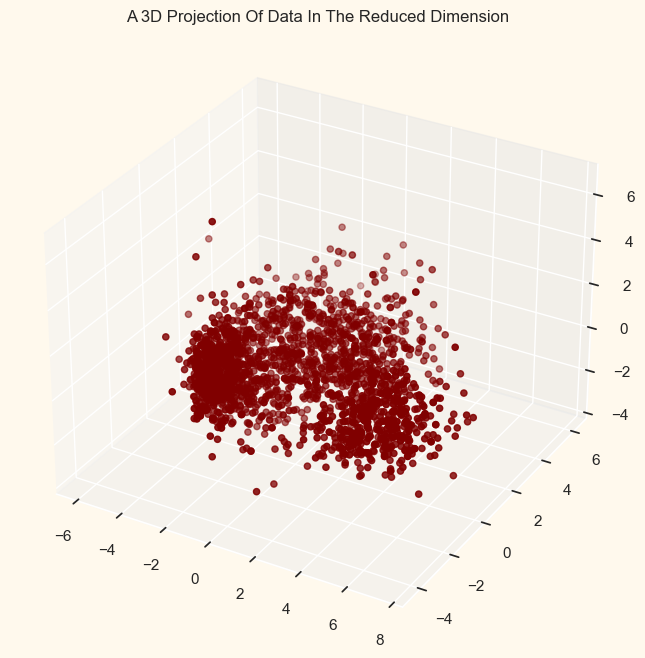

In [157]:

x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()



Elbow Method to determine the number of clusters to be formed:


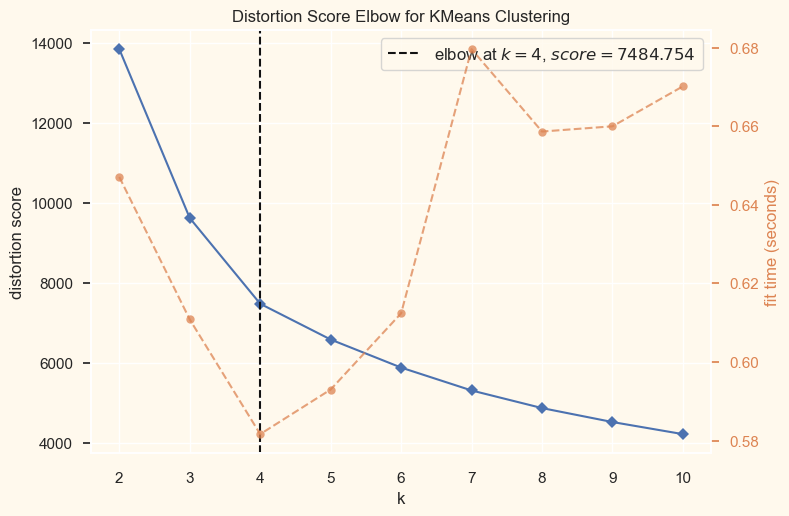

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [158]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [160]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

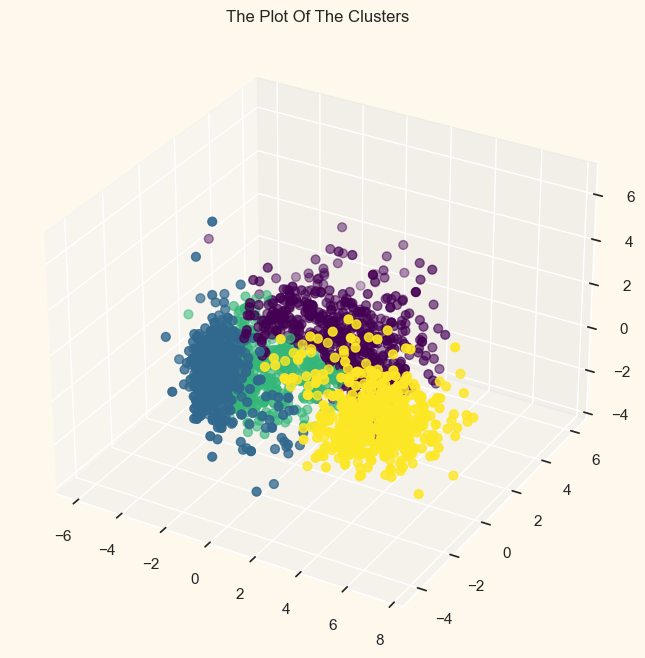

In [161]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

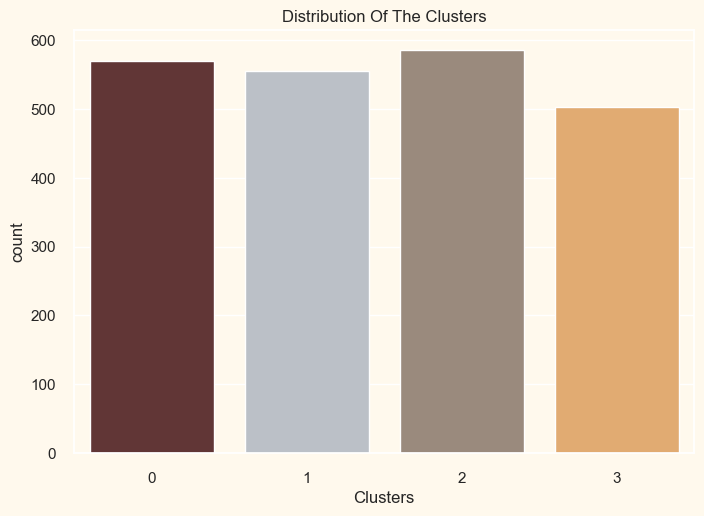

In [162]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

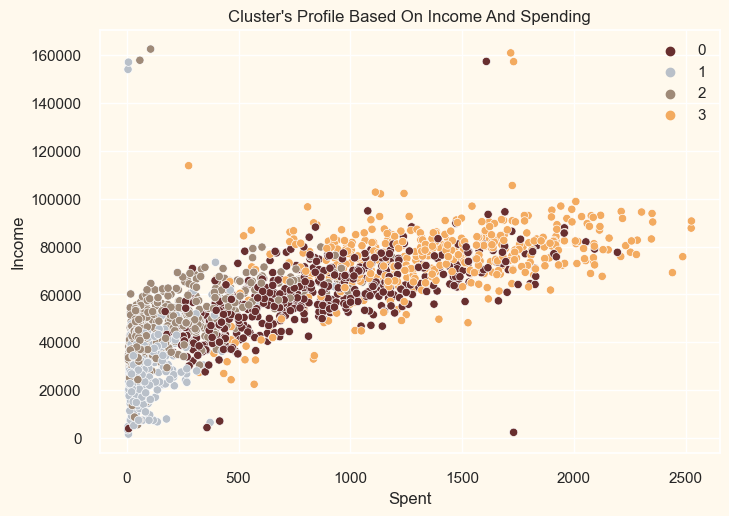

In [163]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

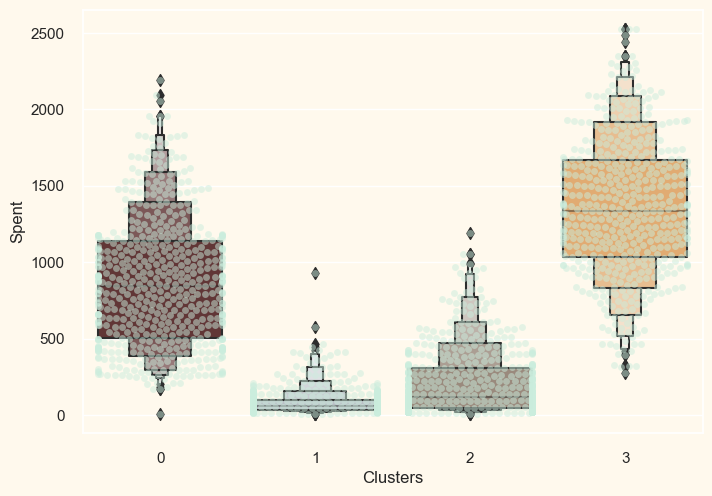

In [171]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

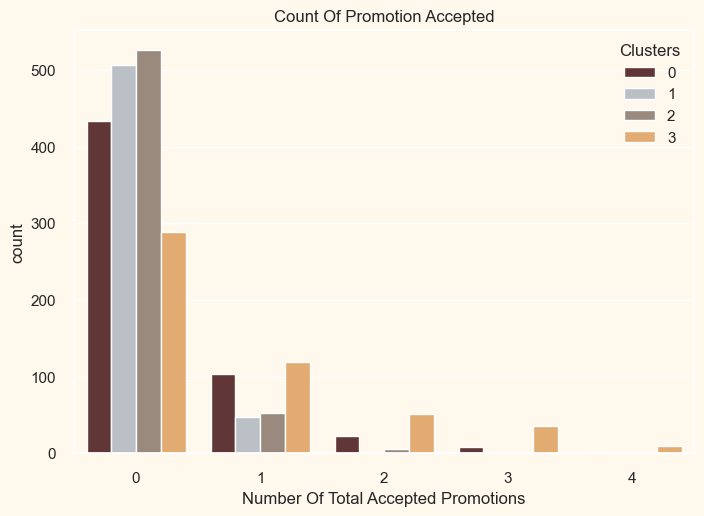

In [165]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()


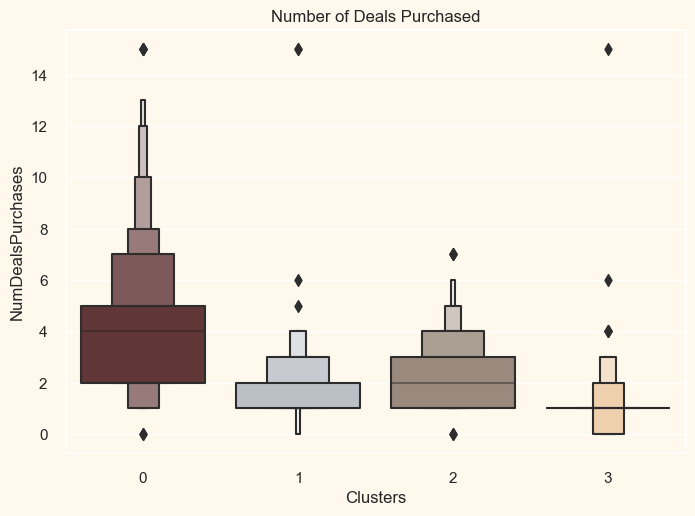

In [166]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

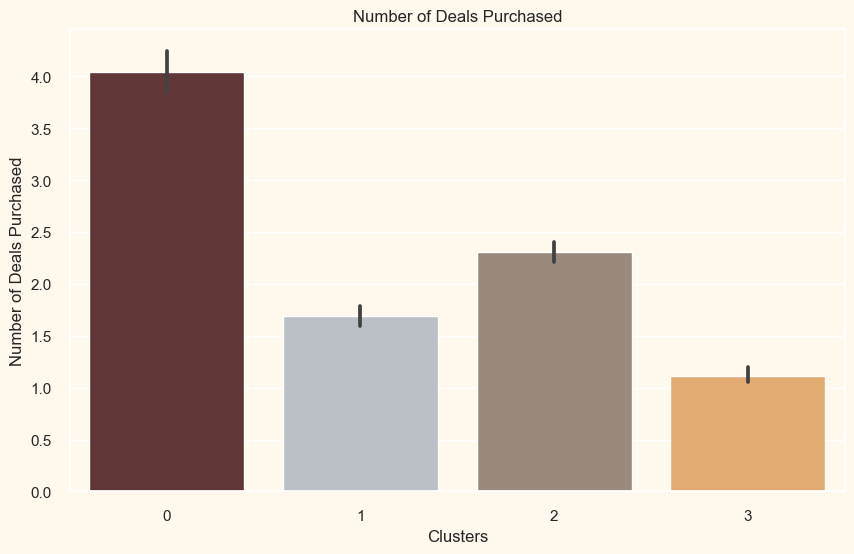

In [167]:
plt.figure(figsize=(10,6))
pl = sns.barplot(x=data["Clusters"], y=data["NumDealsPurchases"], palette=pal)
pl.set_title("Number of Deals Purchased")
plt.xlabel('Clusters')
plt.ylabel('Number of Deals Purchased')
plt.show()


In [168]:
cluster_characteristics = PCA_ds.groupby('Clusters').mean()
print(cluster_characteristics)


              col1      col2      col3
Clusters                              
0         0.543272  2.062984  0.556692
1        -2.100326 -1.806700  0.456639
2        -2.089758  0.521937 -0.881351
3         4.133335 -0.947222 -0.108553


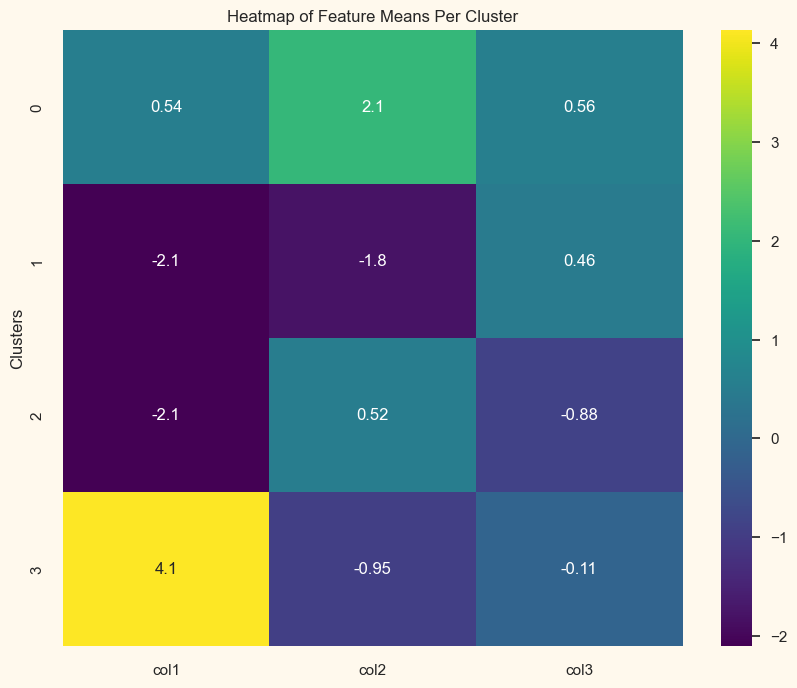

In [169]:
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_characteristics, annot=True, cmap='viridis')
plt.title('Heatmap of Feature Means Per Cluster')
plt.show()


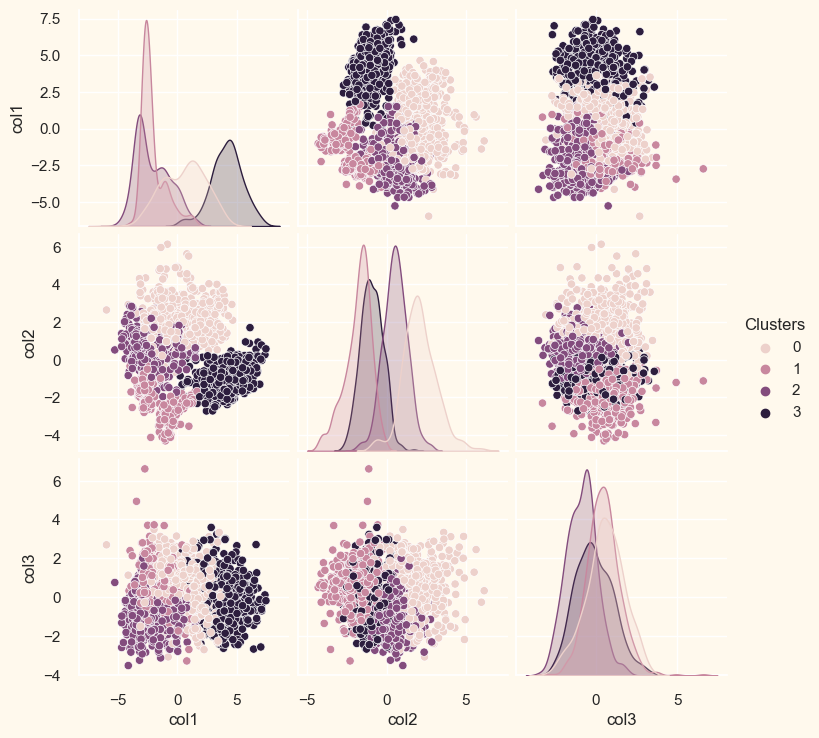

In [170]:
sns.pairplot(PCA_ds, hue='Clusters')
plt.show()


In [173]:
#PROFILING

<Figure size 800x550 with 0 Axes>

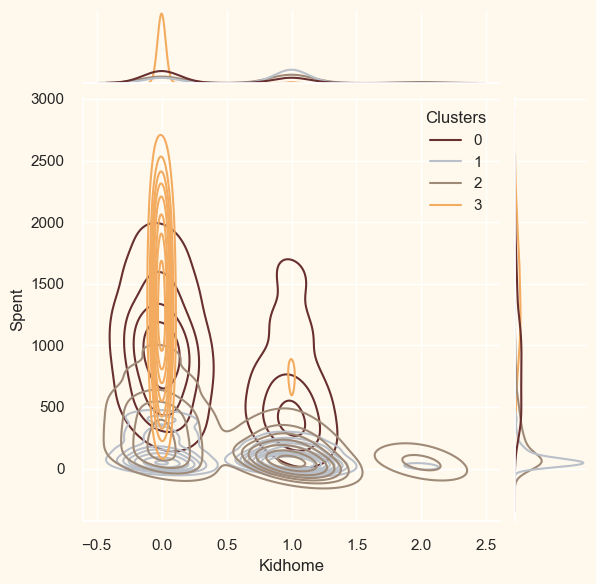

<Figure size 800x550 with 0 Axes>

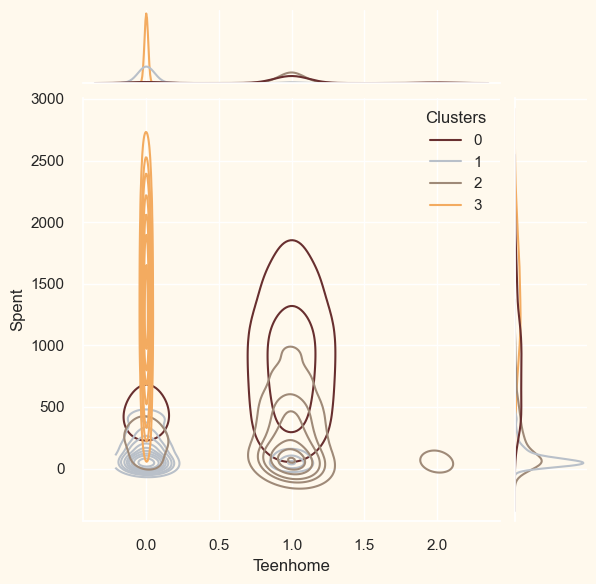

<Figure size 800x550 with 0 Axes>

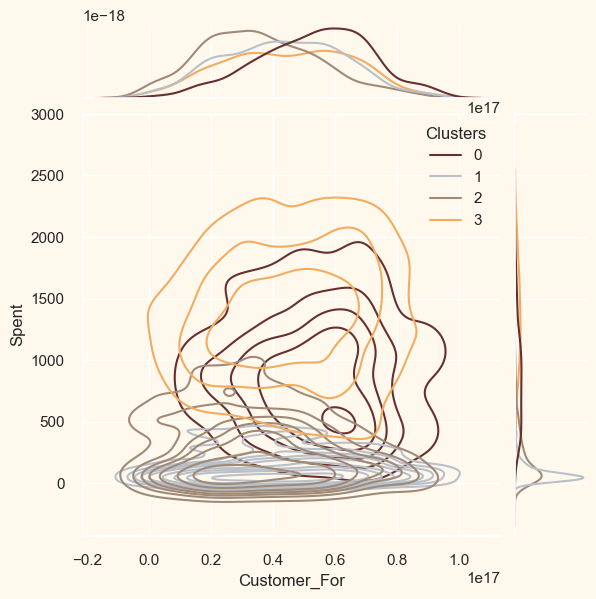

<Figure size 800x550 with 0 Axes>

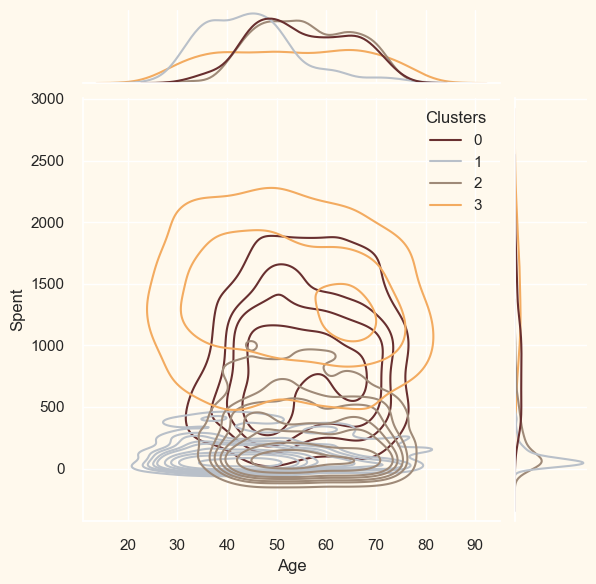

<Figure size 800x550 with 0 Axes>

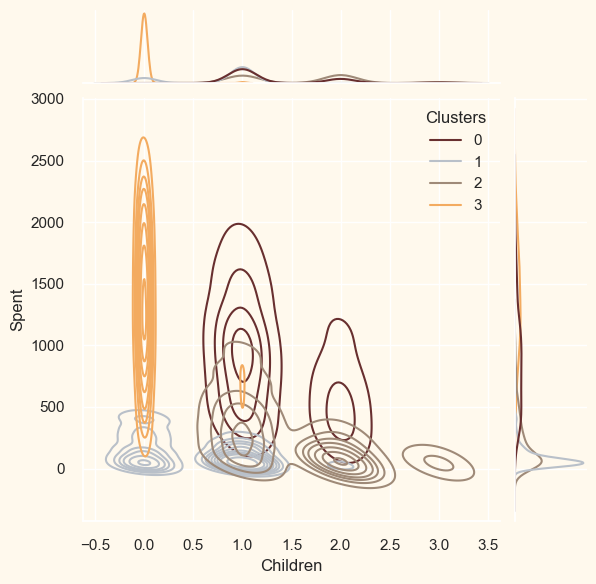

<Figure size 800x550 with 0 Axes>

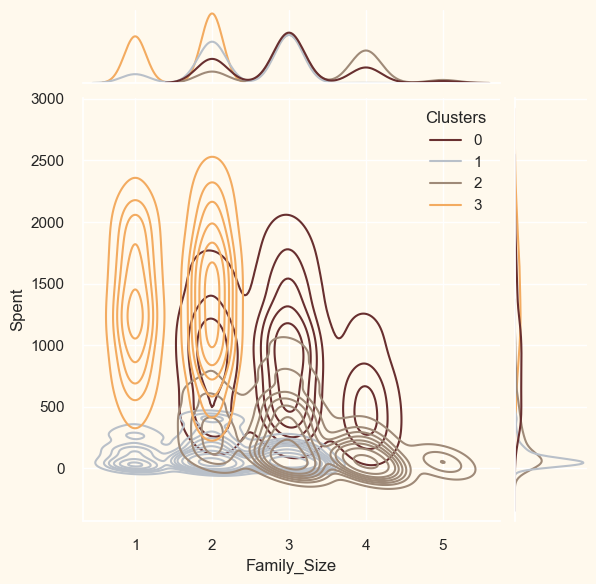

<Figure size 800x550 with 0 Axes>

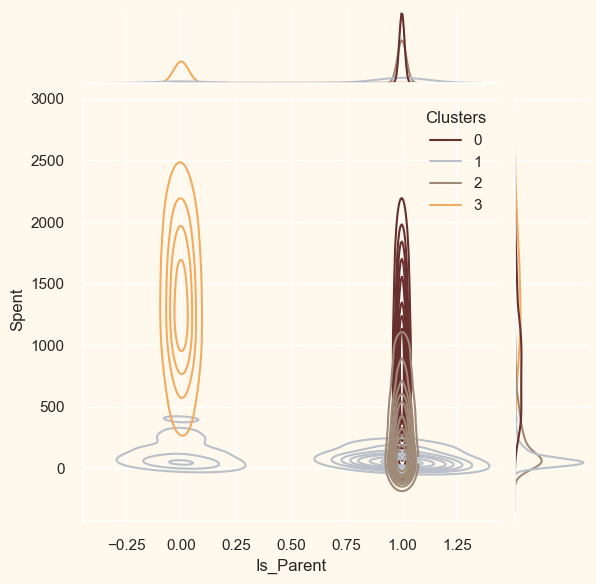

<Figure size 800x550 with 0 Axes>

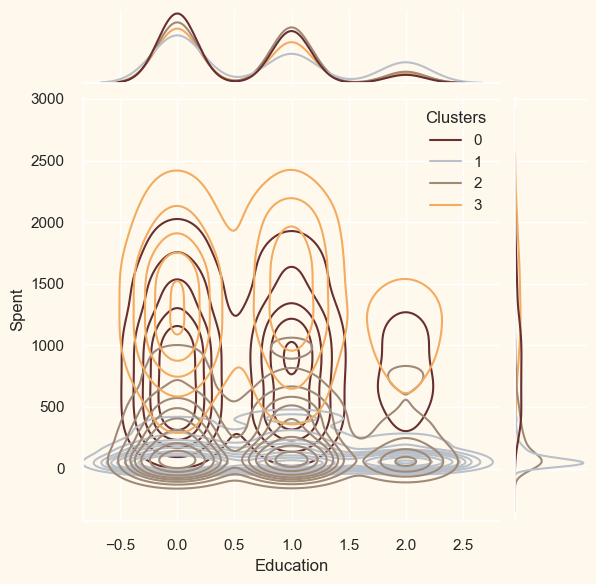

<Figure size 800x550 with 0 Axes>

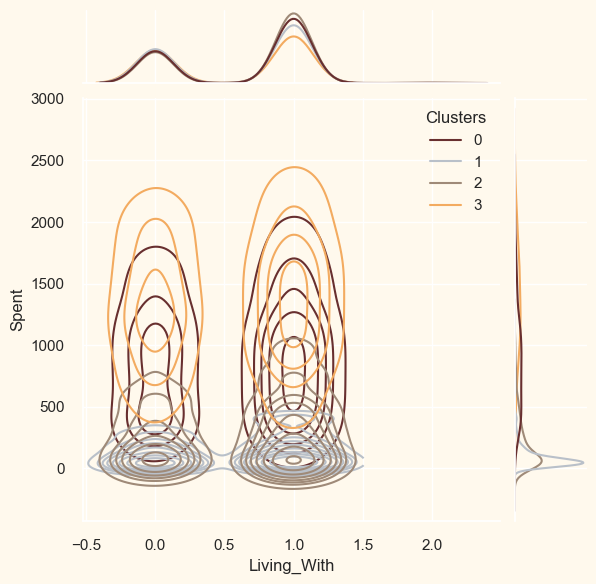

In [177]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()